# Manipulation of CMIP6 model data using Pangeo catalog

## Import python packages

In [3]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

## Open CMIP6 online catalog

In [4]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,518834
dcpp_init_year,60


## Search corresponding data 

In [5]:
cat = col.search(source_id=['CESM2'], experiment_id=['historical'], table_id=['Amon'], variable_id=['tas'], member_id=['r1i1p1f1'])
cat.df


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308


## Create dictionary from the list of datasets we found
- This step may take several minutes so be patient!

In [4]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
list(dset_dict.keys())

['CMIP.NCAR.CESM2.historical.Amon.gn']

## Open dataset

- Use `xarray` python package to analyze netCDF dataset
- `open_dataset` allows to get all the metadata without loading data into memory. 
- with `xarray`, we only load into memory what is needed.

In [6]:
dset = dset_dict['CMIP.NCAR.CESM2.historical.Amon.gn']
dset

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, member_id: 1, nbnd: 2, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    674885.0
    branch_time_in_parent:   219000.0
    case_id:                 15
    ...                      ...
    variable_id:             tas
    variant_info:            CMIP6 20th century experiments (1850-2014) with ...
    variant_label:           r1i1p1f1
    status:                  2019-10-25;created;by nhn2@columbia.edu
    intake_esm_varname:      ['tas']
    intake_esm_dataset_key:  CMIP.NCAR.CESM2.historical.Amon.gn

### Get metadata corresponding to near-surface air temperature (tas)

In [7]:
print(dset['tas'])

<xarray.DataArray 'tas' (member_id: 1, time: 1980, lat: 192, lon: 288)>
dask.array<broadcast_to, shape=(1, 1980, 192, 288), dtype=float32, chunksize=(1, 600, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas


In [8]:
dset.time.values

array([cftime.DatetimeNoLeap(1850, 1, 15, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1850, 2, 14, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1850, 3, 15, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2014, 10, 15, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2014, 11, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2014, 12, 15, 12, 0, 0, 0)], dtype=object)

### Select time

- Select a specific time

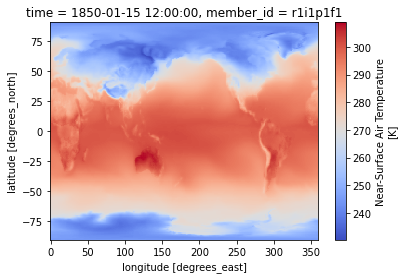

In [9]:
dset['tas'].sel(time=cftime.DatetimeNoLeap(1850, 1, 15, 12, 0, 0, 0, 2, 15)).plot(cmap = 'coolwarm')

- select the nearest time. Here from 1st April 1950

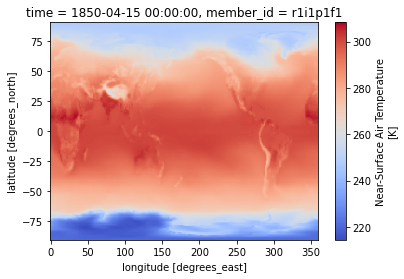

In [10]:
dset['tas'].sel(time=cftime.DatetimeNoLeap(1850, 4, 1), method='nearest').plot(cmap='coolwarm')

# Customize plot

### Set the size of the figure and add coastlines

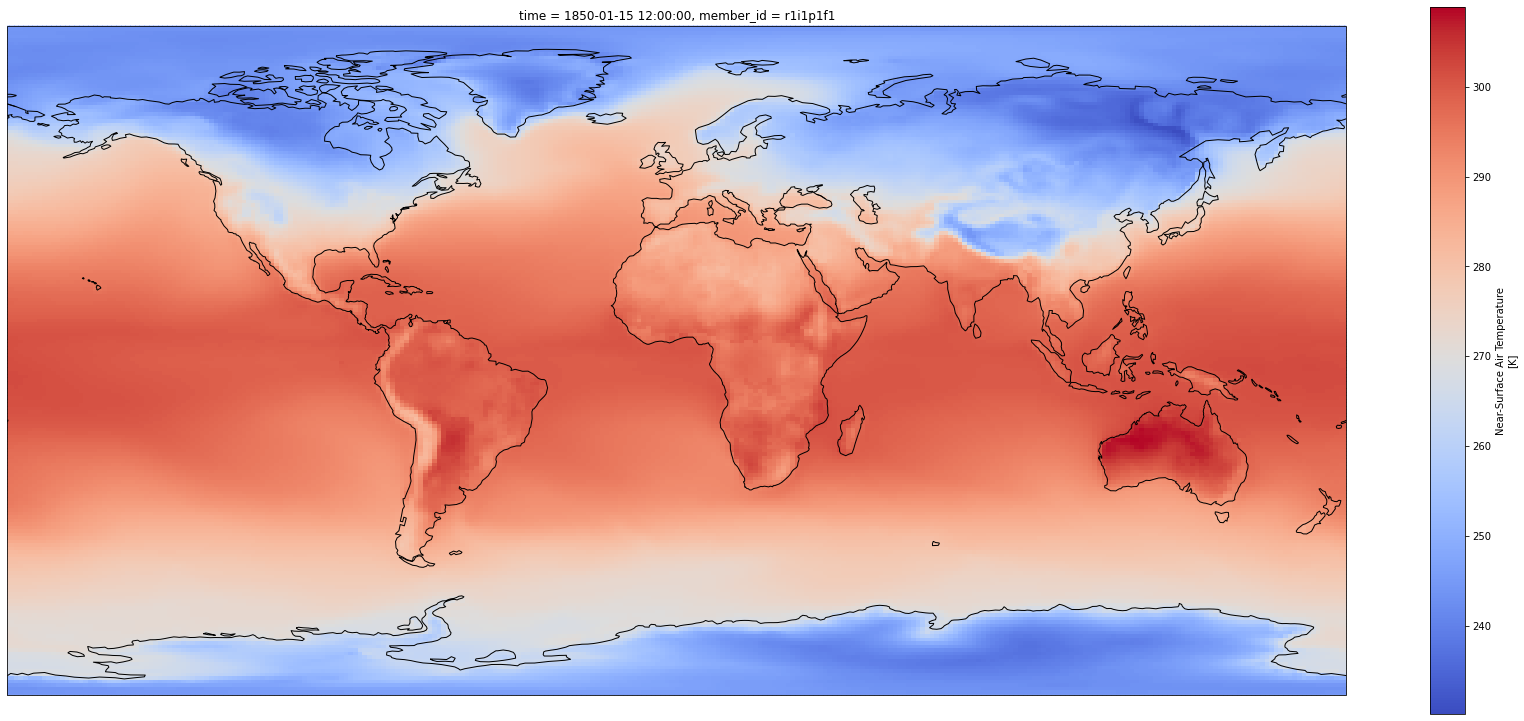

In [11]:
fig = plt.figure(1, figsize=[30,13])

# Set the projection to use for plotting
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()

# Pass ax as an argument when plotting. Here we assume data is in the same coordinate reference system than the projection chosen for plotting
# isel allows to select by indices instead of the time values
dset['tas'].isel(time=0).squeeze().plot.pcolormesh(ax=ax, cmap='coolwarm')

### Change plotting projection

Text(0.5, 1.0, 'January 1850')

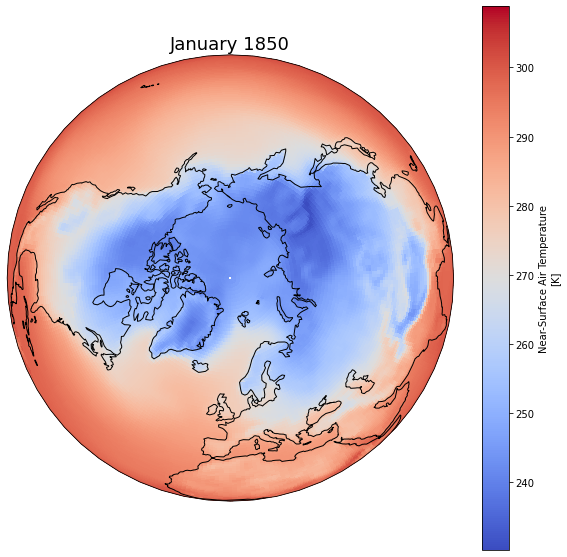

In [12]:
fig = plt.figure(1, figsize=[10,10])

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
dset['tas'].isel(time=0).squeeze().plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')

# One way to customize your title
plt.title(dset.time.values[0].strftime("%B %Y"), fontsize=18)

### Choose the extent of values
- Fix your minimum and maximum values in your plot and
- Use extend so values below the minimum and max

Text(0.5, 1.0, 'January 1850')

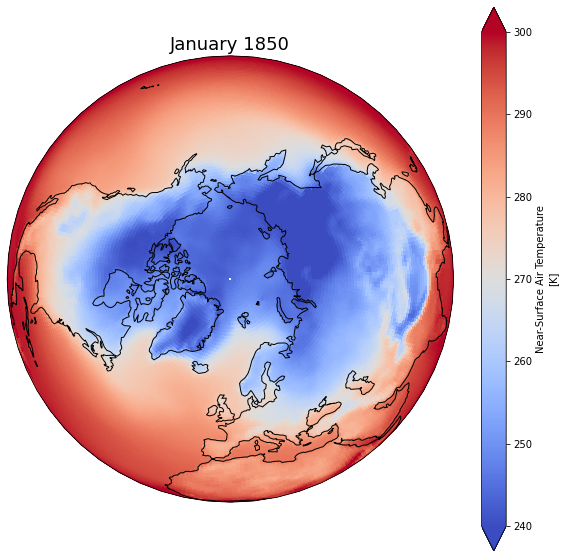

In [13]:
fig = plt.figure(1, figsize=[10,10])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

# Fix extent
minval = 240
maxval = 300

# pass extent with vmin and vmax parameters
dset['tas'].isel(time=0).squeeze().plot(ax=ax, vmin=minval, vmax=maxval, transform=ccrs.PlateCarree(), cmap='coolwarm')

# One way to customize your title
plt.title(dset.time.values[0].strftime("%B %Y"), fontsize=18)

# Multiplots
### Faceting

/opt/conda/lib/python3.8/site-packages/xarray/plot/facetgrid.py:390: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


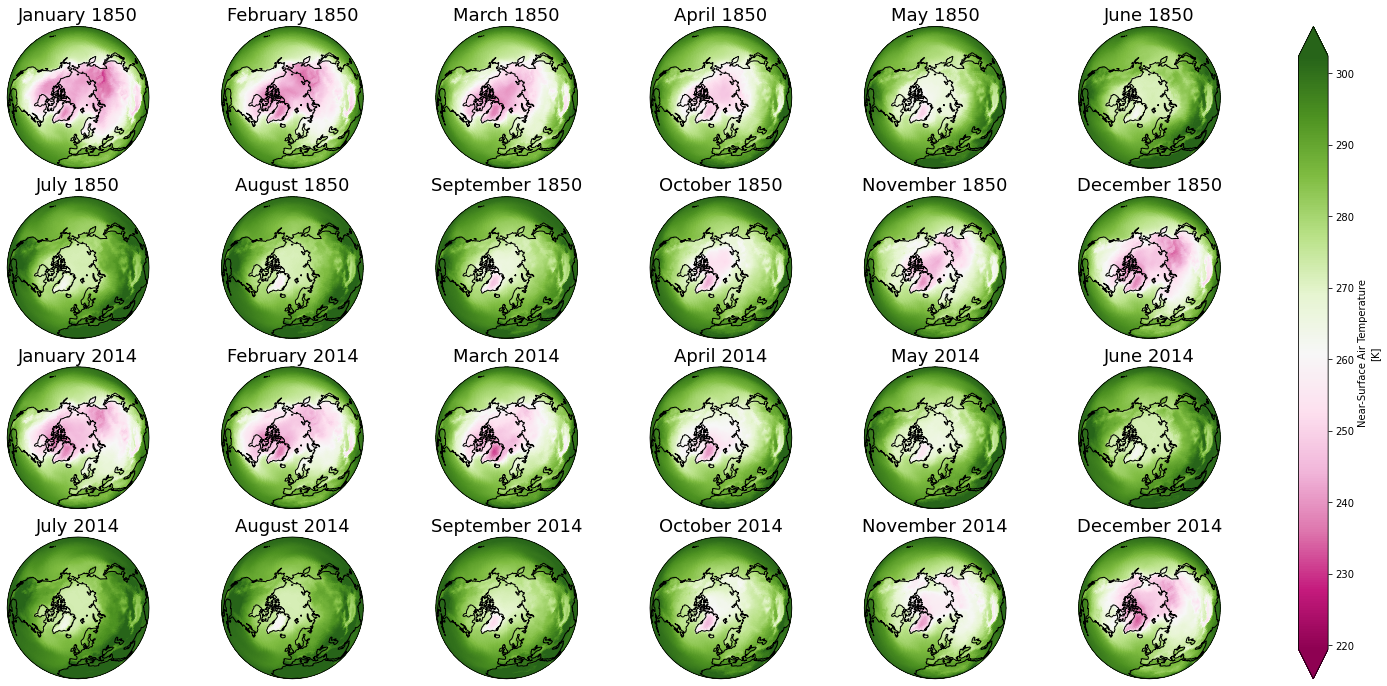

In [14]:
proj_plot = ccrs.Orthographic(0, 90)

p = dset['tas'].sel(time = dset.time.dt.year.isin([1850, 2014])).squeeze().plot(x='lon', y='lat', 
                                                                 transform=ccrs.PlateCarree(),
                                                                 aspect=dset.dims["lon"] / dset.dims["lat"],  # for a sensible figsize
                                                                 subplot_kws={"projection": proj_plot},
                                                                 col='time', col_wrap=6, robust=True, cmap='PiYG')
# We have to set the map's options on all four axes
for ax,i in zip(p.axes.flat,  dset.time.sel(time = dset.time.dt.year.isin([1850, 2014])).values):
    ax.coastlines()
    ax.set_title(i.strftime("%B %Y"), fontsize=18)

### Combine plots with different projections

Text(0, 0.5, 'K')

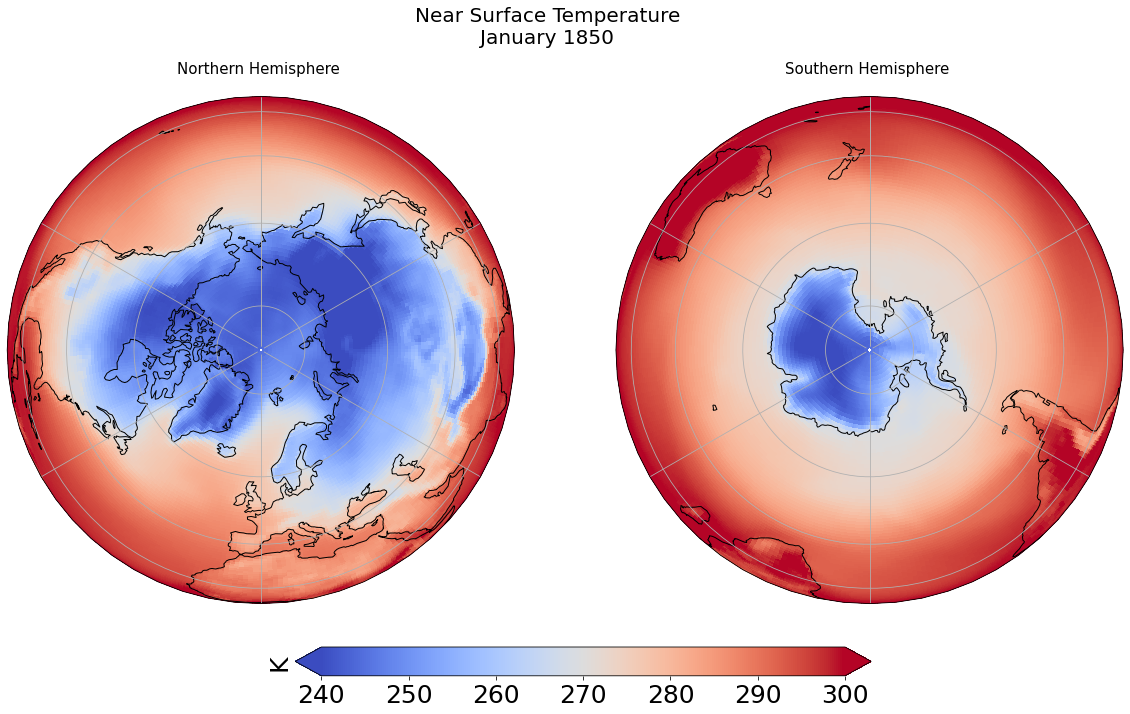

In [15]:
fig = plt.figure(1, figsize=[20,10])

# Fix extent
minval = 240
maxval = 300

# Plot 1 for Northern Hemisphere subplot argument (nrows, ncols, nplot)
# here 1 row, 2 columns and 1st plot
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(0, 90))

# Plot 2 for Southern Hemisphere
# 2nd plot 
ax2 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(180, -90))

tsel = 0
for ax,t in zip([ax1, ax2], ["Northern", "Southern"]):
    map = dset['tas'].isel(time=tsel).squeeze().plot(ax=ax, vmin=minval, vmax=maxval, 
                                           transform=ccrs.PlateCarree(), 
                                           cmap='coolwarm', 
                                           add_colorbar=False)
    ax.set_title(t + " Hemisphere \n" , fontsize=15)
    ax.coastlines()
    ax.gridlines()

# Title for both plots
fig.suptitle('Near Surface Temperature\n' + dset.time.values[tsel].strftime("%B %Y"), fontsize=20)


cb_ax = fig.add_axes([0.325, 0.05, 0.4, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_ylabel('K', fontsize=25)